In [4]:
# Cell 1: CharMap Class
print("--- Defining CharMap Class ---")
import torch
import numpy as np

class CharMap:
    """
    Classe pour mapper les caractères à des indices entiers et vice-versa.
    Gère également le jeton BLANK nécessaire pour la perte CTC.
    """
    def __init__(self, alphabet_string):
        self.SOS_token = None
        self.EOS_token = None
        self.BLANK_token_idx = 0 # L'index du jeton BLANK (généralement 0 pour CTCLoss)

        self.char_to_int = {char: i + 1 for i, char in enumerate(alphabet_string)}
        self.int_to_char = {i + 1: char for i, char in enumerate(alphabet_string)}

        self.int_to_char[self.BLANK_token_idx] = "<BLANK>"
        self.char_to_int["<BLANK>"] = self.BLANK_token_idx

        self.vocab_size = len(self.char_to_int)
        print(f"CharMap initialisé. Taille du vocabulaire (avec BLANK) : {self.vocab_size}")

    def get_char_to_int_map(self):
        return self.char_to_int

    def get_int_to_char_map(self):
        return self.int_to_char

    def get_vocab_size(self):
        return self.vocab_size

    def get_blank_token_idx(self):
        return self.BLANK_token_idx

    def text_to_indices(self, text):
        indices = [self.char_to_int.get(char) for char in text if char in self.char_to_int]
        return [idx for idx in indices if idx is not None]

    def indices_to_text(self, indices, remove_blanks=True, remove_duplicates=True):
        text = []
        last_char_idx = -1
        for idx in indices:
            idx_val = idx.item() if isinstance(idx, torch.Tensor) else idx

            if idx_val == self.BLANK_token_idx and remove_blanks:
                last_char_idx = -1
                continue

            if remove_duplicates and idx_val == last_char_idx:
                continue

            char = self.int_to_char.get(idx_val)
            if char:
                 text.append(char)

            if idx_val != self.BLANK_token_idx:
                 last_char_idx = idx_val
            elif not remove_blanks:
                 last_char_idx = idx_val
        return "".join(text)

print("--- CharMap Class Defined ---\n")

--- Defining CharMap Class ---
--- CharMap Class Defined ---



In [5]:
# Cell 2: VSRDataset Class and collate_fn
print("--- Defining VSRDataset Class and collate_fn ---")
import os
import glob
import cv2
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import random
import traceback

# Assurez-vous que CharMap est défini dans la cellule précédente

class VSRDataset(Dataset):
    def __init__(self, data_root_dir, char_map_instance, img_size=(96, 96), is_train=True, augmentation_prob=0.5, video_metadata_suffix="_metadata.csv", segment_path_col='archive_path', text_col='text'):
        super().__init__()
        print(f"  [VSRDataset __init__] Initializing with data_root_dir: {data_root_dir}")
        self.data_root_dir = data_root_dir
        self.char_map = char_map_instance
        self.img_size = img_size
        self.is_train = is_train
        self.augmentation_prob = augmentation_prob
        self.metadata_list = []

        if not os.path.isdir(self.data_root_dir):
            print(f"  [VSRDataset __init__] ERREUR: Répertoire de base des données introuvable : {self.data_root_dir}")
            return

        print(f"  [VSRDataset __init__] Scanning for video metadata in: {self.data_root_dir} using suffix '{video_metadata_suffix}'")
        print(f"  [VSRDataset __init__] Expecting segment path column: '{segment_path_col}', text column: '{text_col}'")

        processed_video_dirs = 0
        for video_id_dir_name in sorted(os.listdir(self.data_root_dir)):
            video_dir_path = os.path.join(self.data_root_dir, video_id_dir_name)
            if os.path.isdir(video_dir_path):
                processed_video_dirs += 1
                metadata_csv_name = f"{video_id_dir_name}{video_metadata_suffix}"
                video_metadata_csv_path = os.path.join(video_dir_path, metadata_csv_name)

                if os.path.exists(video_metadata_csv_path):
                    try:
                        video_df = pd.read_csv(video_metadata_csv_path)
                        # print(f"    [VSRDataset __init__] Processing metadata: {video_metadata_csv_path} ({len(video_df)} segments found).") # Less verbose
                        missing_col_warning_shown = False
                        for idx, row in video_df.iterrows():
                            path_from_csv = row.get(segment_path_col)
                            text_label = row.get(text_col)
                            path_missing = pd.isna(path_from_csv) or not path_from_csv
                            text_missing = pd.isna(text_label) or not text_label

                            if not path_missing and not text_missing:
                                relative_segment_dir_path = str(path_from_csv).replace('.zip', '')
                                full_segment_dir_path = os.path.join(self.data_root_dir, relative_segment_dir_path)
                                if os.path.isdir(full_segment_dir_path):
                                    self.metadata_list.append({
                                        'segment_dir_path': full_segment_dir_path,
                                        'text': str(text_label)
                                    })
                                # else: # Reduced warning verbosity
                                    # print(f"      [VSRDataset __init__] Avertissement: Segment DIRECTORY non trouvé: {full_segment_dir_path}")
                            # else: # Reduced warning verbosity
                                # if not missing_col_warning_shown:
                                     # print(f"      [VSRDataset __init__] Avertissement: Colonnes manquantes dans {video_metadata_csv_path}.")
                                     # missing_col_warning_shown = True
                    except pd.errors.EmptyDataError: print(f"    [VSRDataset __init__] Avertissement: Metadata file {video_metadata_csv_path} is empty.")
                    except Exception as e: print(f"    [VSRDataset __init__] ERREUR lors de la lecture de {video_metadata_csv_path}: {e}"); traceback.print_exc()
                # else: # Reduced warning verbosity
                    # print(f"    [VSRDataset __init__] Avertissement: Fichier metadata {video_metadata_csv_path} non trouvé.")

        print(f"  [VSRDataset __init__] Scanned {processed_video_dirs} potential video directories.")
        if not self.metadata_list:
            print(f"  [VSRDataset __init__] ERREUR: Aucune métadonnée de segment valide trouvée.")
        else:
            print(f"  [VSRDataset __init__] Total de {len(self.metadata_list)} échantillons de segments chargés.")

    def __len__(self):
        return len(self.metadata_list)

    def __getitem__(self, idx):
        if idx >= len(self.metadata_list):
            raise IndexError("Index hors limites")

        sample_info = self.metadata_list[idx]
        segment_dir_path = sample_info['segment_dir_path']
        text_label = str(sample_info['text'])
        frames = []
        try:
            frame_files = sorted(glob.glob(os.path.join(segment_dir_path, '*.png')))
            frame_files += sorted(glob.glob(os.path.join(segment_dir_path, '*.jpg')))
            frame_files += sorted(glob.glob(os.path.join(segment_dir_path, '*.jpeg')))

            if not frame_files: return None
            for frame_filepath in frame_files:
                img_bgr = cv2.imread(frame_filepath, cv2.IMREAD_COLOR)
                if img_bgr is None: continue
                img_resized = cv2.resize(img_bgr, self.img_size, interpolation=cv2.INTER_LINEAR)
                img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
                if self.is_train and random.random() < self.augmentation_prob:
                    img_gray = cv2.flip(img_gray, 1)
                img_normalized = img_gray.astype(np.float32) / 255.0
                frames.append(img_normalized)
        except Exception as e:
            # print(f"  [VSRDataset __getitem__] ERREUR: Index {idx} ({segment_dir_path}): {e}") # Less verbose
            return None

        if not frames: return None
        frames_tensor = torch.tensor(np.array(frames), dtype=torch.float32).unsqueeze(1)
        text_indices = self.char_map.text_to_indices(text_label)
        if not text_indices: return None
        text_tensor = torch.tensor(text_indices, dtype=torch.long)
        return frames_tensor, text_tensor

def collate_fn(batch, char_map_instance_for_collate):
    batch = [item for item in batch if item is not None]
    if not batch:
        # print("  [collate_fn] Warning: Received an entirely empty batch after filtering Nones.") # Less verbose
        return None

    sequences, targets = zip(*batch)
    seq_lengths = torch.tensor([s.size(0) for s in sequences], dtype=torch.long)
    target_lengths = torch.tensor([t.size(0) for t in targets], dtype=torch.long)

    padded_sequences = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0.0)
    padded_targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=char_map_instance_for_collate.get_blank_token_idx())
    return padded_sequences, padded_targets, seq_lengths, target_lengths

print("--- VSRDataset Class (Directory Mode) and collate_fn Defined ---\n")

--- Defining VSRDataset Class and collate_fn ---
--- VSRDataset Class (Directory Mode) and collate_fn Defined ---



In [6]:
# Cell 3: New Model Definition - NewVSRModel
print("--- Defining NewVSRModel Class ---")
import torch
import torch.nn as nn
import torch.nn.functional as F

class NewVSRModel(nn.Module):
    def __init__(self, num_classes, input_channel=1, rnn_hidden_size=256, rnn_num_layers=2, bottleneck_dim=256):
        super(NewVSRModel, self).__init__()
        # print(f"  [NewVSRModel __init__] Initializing model with num_classes={num_classes}, RNN hidden_size={rnn_hidden_size}, Bottleneck={bottleneck_dim}") # Less verbose

        self.frontend3D = nn.Sequential(
            nn.Conv3d(input_channel, 64, kernel_size=(3, 5, 5), stride=(1, 2, 2), padding=(1, 2, 2), bias=False),
            nn.BatchNorm3d(64), nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1)),
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False),
            nn.BatchNorm3d(128), nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 0, 0))
        )
        self.frontend3D_output_channels = 128

        self.backend2D = nn.Sequential(
            nn.Conv2d(self.frontend3D_output_channels, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(inplace=True)
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1,1))
        self.backend2D_output_features = 512

        self.bottleneck_linear = nn.Linear(self.backend2D_output_features, bottleneck_dim)
        self.bottleneck_relu = nn.ReLU(inplace=True)

        self.blstm1 = nn.LSTM(bottleneck_dim, rnn_hidden_size, num_layers=rnn_num_layers,
                              bidirectional=True, batch_first=True, dropout=0.2 if rnn_num_layers > 1 else 0)
        self.blstm2 = nn.LSTM(rnn_hidden_size * 2, rnn_hidden_size, num_layers=rnn_num_layers,
                              bidirectional=True, batch_first=True, dropout=0.2 if rnn_num_layers > 1 else 0)
        self.output_linear = nn.Linear(rnn_hidden_size * 2, num_classes)
        # print("  [NewVSRModel __init__] Model Initialization Complete.") # Less verbose

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.permute(0, 2, 1, 3, 4)
        x = self.frontend3D(x)
        x = x.permute(0, 2, 1, 3, 4)
        C_3D_out = x.size(2)
        x = x.contiguous().view(B * T, C_3D_out, x.size(3), x.size(4))
        x = self.backend2D(x)
        x = self.adaptive_pool(x)
        x = x.view(B * T, -1)
        x = x.view(B, T, self.backend2D_output_features)
        x = self.bottleneck_linear(x)
        x = self.bottleneck_relu(x)
        self.blstm1.flatten_parameters()
        x, _ = self.blstm1(x)
        self.blstm2.flatten_parameters()
        x, _ = self.blstm2(x)
        x = self.output_linear(x)
        output_log_probs = F.log_softmax(x, dim=2)
        return output_log_probs

print("--- NewVSRModel Class Defined ---\n")

--- Defining NewVSRModel Class ---
--- NewVSRModel Class Defined ---



In [10]:
# Cell 4: Configuration
print("--- Configuring Training Parameters ---")
import torch
import torch.nn as nn # For CTCLoss definition later
import torch.optim as optim # For Optimizer definition later
from functools import partial
import os

# --- Path Configurations ---
KAGGLE_DATASET_ROOT_DIR = "/kaggle/input/30fpsdata/DATA" # Adjust if your data path changes

# Path for LOADING checkpoint to RESUME training
PRETRAINED_WEIGHTS_FILENAME = "vsr_checkpoint_16_05_01am.pth" # FILENAME OF THE CHECKPOINT TO LOAD
PRETRAINED_WEIGHTS_PATH = f"/kaggle/input/trained-on-30fps-data/pytorch/default/1/{PRETRAINED_WEIGHTS_FILENAME}"

# Path for SAVING NEW checkpoints during this training session
NEW_CHECKPOINT_SAVE_FILENAME = "vsr_checkpoint_16_05_09pm.pth" # New name for checkpoints saved during this run
NEW_CHECKPOINT_SAVE_PATH = f"/kaggle/working/{NEW_CHECKPOINT_SAVE_FILENAME}"
# Path for saving the final model after this training session
FINAL_MODEL_SAVE_FILENAME = "model_fully_trained_16_05_09pm.pth"
FINAL_MODEL_SAVE_PATH = f"/kaggle/working/{FINAL_MODEL_SAVE_FILENAME}"

print(f"Dataset Root Directory: {KAGGLE_DATASET_ROOT_DIR}")
print(f"Loading checkpoint from: {PRETRAINED_WEIGHTS_PATH}")
print(f"Saving new checkpoints to: {NEW_CHECKPOINT_SAVE_PATH}")
print(f"Saving final model to: {FINAL_MODEL_SAVE_PATH}")

# --- Image Parameters ---
IMG_HEIGHT = 96
IMG_WIDTH = 96
print(f"Image Size set to: ({IMG_HEIGHT}, {IMG_WIDTH})")

# --- Model Hyperparameters (ensure these match the NewVSRModel used for the checkpoint) ---
GRU_HIDDEN_DIM = 256
GRU_NUM_LAYERS = 2 # As used in your NewVSRModel instantiation
BOTTLENECK_DIM = 256 # As used in your NewVSRModel instantiation

# --- Training Hyperparameters ---
NUM_EPOCHS = 200 # Total epochs desired (e.g., if checkpoint is at epoch 10 and you want 10 more, set to 20)
BATCH_SIZE = 4
LEARNING_RATE_OTHERS = 1e-4 # Initial LR for optimizer (will be loaded from checkpoint if available)
# Note: LEARNING_RATE_RESNET was for a different model structure. For NewVSRModel, optimizer groups might be different or a single LR used.
# The optimizer state from the checkpoint will manage LRs if loaded correctly.

NUM_WORKERS = 2
start_epoch = 0 # Will be updated if loaded from checkpoint

print(f"Target Total Epochs: {NUM_EPOCHS}, Batch Size: {BATCH_SIZE}, Initial LR: {LEARNING_RATE_OTHERS}")

# --- Alphabet and CharMap ---
arabic_alphabet_str = " اأبتثجحخدذرزسشصضطظعغفقكلمنهويىءؤئآة"
try:
    char_map_instance = CharMap(arabic_alphabet_str)
    NUM_CLASSES = char_map_instance.vocab_size
    print(f"Alphabet defined. Number of classes (incl. blank): {NUM_CLASSES}")
except NameError:
     print("ERREUR: CharMap class not defined. Please run Cell 1 first.")
     char_map_instance = None
     NUM_CLASSES = -1 # Should not happen

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

# --- Collate Function ---
collate_function_with_charmap = None
if 'collate_fn' in globals() and char_map_instance:
    collate_function_with_charmap = partial(collate_fn, char_map_instance_for_collate=char_map_instance)
    print("Partial collate function created.")
else:
    print("ERREUR: collate_fn or char_map_instance not defined for partial collate_fn.")

print("--- Configuration Done ---\n")

--- Configuring Training Parameters ---
Dataset Root Directory: /kaggle/input/30fpsdata/DATA
Loading checkpoint from: /kaggle/input/trained-on-30fps-data/pytorch/default/1/vsr_checkpoint_16_05_01am.pth
Saving new checkpoints to: /kaggle/working/vsr_checkpoint_16_05_09pm.pth
Saving final model to: /kaggle/working/model_fully_trained_16_05_09pm.pth
Image Size set to: (96, 96)
Target Total Epochs: 200, Batch Size: 4, Initial LR: 0.0001
CharMap initialisé. Taille du vocabulaire (avec BLANK) : 37
Alphabet defined. Number of classes (incl. blank): 37
Using device: cuda
CUDA Device Name: Tesla P100-PCIE-16GB
Partial collate function created.
--- Configuration Done ---



In [11]:
# Cell 5: Initialize Components & Load Checkpoint
print("--- Initializing Training Components & Loading Checkpoint ---")
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import traceback
import os

# Initialize components to None
train_dataset = None
train_loader = None
model = None
optimizer = None
ctc_loss_fn = None
# start_epoch is already initialized in Cell 4

# --- 1. Instantiate Dataset and DataLoader ---
if KAGGLE_DATASET_ROOT_DIR and char_map_instance and collate_function_with_charmap:
    try:
        print("  [Init Components] Instantiating VSRDataset...")
        train_dataset = VSRDataset(
            data_root_dir=KAGGLE_DATASET_ROOT_DIR,
            char_map_instance=char_map_instance,
            img_size=(IMG_HEIGHT, IMG_WIDTH),
            is_train=True, # Set to True for training
            augmentation_prob=0.5, # Or your desired value
            video_metadata_suffix="_metadata.csv",
            segment_path_col='archive_path',
            text_col='text'
        )
        if len(train_dataset) == 0:
            print("  [Init Components] ERREUR: train_dataset is empty.")
            train_dataset = None # Ensure it's None if empty
        else:
            print(f"  [Init Components] VSRDataset created with {len(train_dataset)} samples.")
            print("  [Init Components] Creating DataLoader...")
            train_loader = DataLoader(
                dataset=train_dataset,
                batch_size=BATCH_SIZE,
                shuffle=True,
                collate_fn=collate_function_with_charmap,
                num_workers=NUM_WORKERS,
                pin_memory=True if device.type == "cuda" else False,
                persistent_workers=True if NUM_WORKERS > 0 else False
            )
            print(f"  [Init Components] DataLoader created with {len(train_loader)} batches.")
    except Exception as e:
        print(f"  [Init Components] ERREUR during Dataset/DataLoader creation: {e}"); traceback.print_exc()
        train_loader = None
        train_dataset = None
else:
    print("  [Init Components] Skipping Dataset/DataLoader: Missing config (e.g., data_root_dir, char_map, collate_fn).")


# --- 2. Instantiate Model, Optimizer, and Load Checkpoint (if loader is ready) ---
if train_loader:
    try:
        print("  [Init Components] Instantiating NewVSRModel...")
        model = NewVSRModel(
            num_classes=NUM_CLASSES,
            input_channel=1, # Assuming grayscale
            rnn_hidden_size=GRU_HIDDEN_DIM,
            rnn_num_layers=GRU_NUM_LAYERS,
            bottleneck_dim=BOTTLENECK_DIM
        ).to(device)
        print(f"  [Init Components] NewVSRModel instantiated on {device}.")

        print("  [Init Components] Defining Optimizer...")
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE_OTHERS)
        print("  [Init Components] AdamW Optimizer defined.")

        # --- Load Checkpoint ---
        if os.path.exists(PRETRAINED_WEIGHTS_PATH):
            print(f"  [Init Components] Checkpoint found at {PRETRAINED_WEIGHTS_PATH}. Loading...")
            checkpoint = torch.load(PRETRAINED_WEIGHTS_PATH, map_location=device)

            if 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
                print("  [Init Components] Loaded model_state_dict from checkpoint.")
            else:
                print("  [Init Components] Warning: model_state_dict not found in checkpoint.")

            if 'optimizer_state_dict' in checkpoint and optimizer is not None:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                print("  [Init Components] Loaded optimizer_state_dict from checkpoint.")
            else:
                print("  [Init Components] Warning: optimizer_state_dict not found or optimizer is None.")

            if 'epoch' in checkpoint:
                start_epoch = checkpoint['epoch'] + 1 # Resume from NEXT epoch
                print(f"  [Init Components] Resuming training from epoch {start_epoch}.")
            else:
                print("  [Init Components] Warning: Epoch number not found in checkpoint. Will use default start_epoch.")
            print("  [Init Components] Checkpoint loading process finished.")
        else:
            print(f"  [Init Components] No checkpoint file found at {PRETRAINED_WEIGHTS_PATH}. Starting fresh or with random weights.")

        # --- 3. Define Loss Function ---
        print("  [Init Components] Defining CTCLoss...")
        ctc_loss_fn = nn.CTCLoss(blank=char_map_instance.get_blank_token_idx(),
                                 reduction='mean',
                                 zero_infinity=True).to(device)
        print("  [Init Components] CTCLoss defined.")

    except Exception as e:
        print(f"  [Init Components] ERREUR during Model/Optimizer/Loss setup: {e}")
        traceback.print_exc()
        model = None # Ensure components are None if setup fails
        optimizer = None
        ctc_loss_fn = None
else:
    print("  [Init Components] Skipping Model/Optimizer/Loss setup because DataLoader was not created.")

print(f"--- Initialization of Training Components Done. Training will attempt to resume/start from epoch: {start_epoch} ---")

--- Initializing Training Components & Loading Checkpoint ---
  [Init Components] Instantiating VSRDataset...
  [VSRDataset __init__] Initializing with data_root_dir: /kaggle/input/30fpsdata/DATA
  [VSRDataset __init__] Scanning for video metadata in: /kaggle/input/30fpsdata/DATA using suffix '_metadata.csv'
  [VSRDataset __init__] Expecting segment path column: 'archive_path', text column: 'text'
  [VSRDataset __init__] Scanned 8 potential video directories.
  [VSRDataset __init__] Total de 1295 échantillons de segments chargés.
  [Init Components] VSRDataset created with 1295 samples.
  [Init Components] Creating DataLoader...
  [Init Components] DataLoader created with 324 batches.
  [Init Components] Instantiating NewVSRModel...
  [Init Components] NewVSRModel instantiated on cuda.
  [Init Components] Defining Optimizer...
  [Init Components] AdamW Optimizer defined.
  [Init Components] Checkpoint found at /kaggle/input/trained-on-30fps-data/pytorch/default/1/vsr_checkpoint_16_05_0

/tmp/ipykernel_31/3961821092.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PRETRAINED_WEIGHTS_PATH, map_location=device)


  [Init Components] Loaded model_state_dict from checkpoint.
  [Init Components] Loaded optimizer_state_dict from checkpoint.
  [Init Components] Resuming training from epoch 110.
  [Init Components] Checkpoint loading process finished.
  [Init Components] Defining CTCLoss...
  [Init Components] CTCLoss defined.
--- Initialization of Training Components Done. Training will attempt to resume/start from epoch: 110 ---


In [12]:
# Cell 6: Training Loop
print("--- Starting Training Loop ---")
import torch # Ensure torch is in scope
import traceback

# Check if all necessary components are ready
if train_loader and model and ctc_loss_fn and optimizer and char_map_instance:
    print(f"Training will run from epoch {start_epoch} up to {NUM_EPOCHS-1} (target total epochs: {NUM_EPOCHS}).")
    print(f"Device: {device}")

    if len(train_loader) == 0:
        print("  [Training Loop] ERREUR: train_loader is empty. Cannot start training.")
    else:
        total_batches_per_epoch = len(train_loader)
        print(f"Total batches per epoch: {total_batches_per_epoch}")

        model.train() # Ensure model is in training mode initially

        for epoch in range(start_epoch, NUM_EPOCHS):
            print(f"\n--- Starting Epoch {epoch+1}/{NUM_EPOCHS} (current loop index: {epoch}) ---")
            model.train() # Set model to training mode at the start of each epoch
            epoch_loss = 0.0
            processed_batches_in_epoch = 0

            for batch_idx, data_batch in enumerate(train_loader):
                if data_batch is None:
                    print(f"  Epoch {epoch+1}, Batch {batch_idx+1}/{total_batches_per_epoch}: Skipper (None batch).")
                    continue
                try:
                    padded_sequences_batch_first, padded_targets, seq_lengths, target_lengths = data_batch

                    if torch.any(target_lengths <= 0) or torch.any(seq_lengths <= 0):
                        # print(f"  Epoch {epoch+1}, Batch {batch_idx+1}: Invalid lengths, skipping.") # Less verbose
                        continue

                    padded_sequences_batch_first = padded_sequences_batch_first.to(device)
                    padded_targets_cpu = padded_targets.cpu() # Targets for CTCLoss on CPU
                    seq_lengths_cpu = seq_lengths.cpu()
                    target_lengths_cpu = target_lengths.cpu()

                    optimizer.zero_grad()
                    output_log_probs = model(padded_sequences_batch_first) # (B, T, NumClasses)
                    output_log_probs_permuted = output_log_probs.permute(1, 0, 2) # (T, B, NumClasses) for CTCLoss

                    model_output_temporal_len = output_log_probs_permuted.size(0)
                    # Clamp input_lengths for CTCLoss to be <= model's output T
                    ctc_input_lengths = torch.clamp(seq_lengths_cpu, max=model_output_temporal_len)

                    if torch.any(ctc_input_lengths <= 0):
                        # print(f"  Epoch {epoch+1}, Batch {batch_idx+1}: CTC input length <=0, skipping.") # Less verbose
                        continue
                    
                    # CTCLoss expects targets on CPU
                    loss = ctc_loss_fn(output_log_probs_permuted, padded_targets_cpu, ctc_input_lengths, target_lengths_cpu)

                    if torch.isnan(loss) or torch.isinf(loss):
                        print(f"  Epoch {epoch+1}, Batch {batch_idx+1}: NaN/Inf loss ({loss.item()}), skipping backward.")
                        continue

                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0) # Optional gradient clipping
                    optimizer.step()

                    current_loss = loss.item()
                    epoch_loss += current_loss
                    processed_batches_in_epoch += 1

                    if (batch_idx + 1) % 20 == 0 or (batch_idx + 1) == total_batches_per_epoch: # Log less frequently
                        print(f"  Epoch {epoch+1}, Batch {batch_idx+1}/{total_batches_per_epoch}, Loss: {current_loss:.6f}")

                except RuntimeError as e_runtime:
                    print(f"  RUNTIME ERROR (Batch {batch_idx+1}): {e_runtime}")
                    # print(f"    CTC Inputs - In: {ctc_input_lengths.tolist()}, Tgt: {target_lengths_cpu.tolist()}, Model T: {model_output_temporal_len}") # Verbose debug
                    # traceback.print_exc() # Very verbose
                    print("    Skipping batch due to CTCLoss error (likely target_length > input_length).")
                    continue
                except Exception as e_batch:
                    print(f"  UNEXPECTED BATCH ERROR (Batch {batch_idx+1}): {e_batch}")
                    traceback.print_exc() # Keep for unexpected errors

            avg_epoch_loss = 0.0
            if processed_batches_in_epoch > 0:
                avg_epoch_loss = epoch_loss / processed_batches_in_epoch
                print(f"--- Finished Epoch {epoch+1}/{NUM_EPOCHS}, Avg Training Loss: {avg_epoch_loss:.6f} ---")

                # Save checkpoint
                print(f"    Saving checkpoint for epoch {epoch} to {NEW_CHECKPOINT_SAVE_PATH}...")
                torch.save({
                    'epoch': epoch, # Save the epoch that was just completed
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': avg_epoch_loss,
                }, NEW_CHECKPOINT_SAVE_PATH)
                print(f"    Checkpoint saved successfully for epoch {epoch}.")
            else:
                print(f"--- Finished Epoch {epoch+1}/{NUM_EPOCHS}, No batches processed successfully. ---")

        print("\n--- Training Loop Finished ---")

        # Save the final model state dict
        try:
            torch.save(model.state_dict(), FINAL_MODEL_SAVE_PATH)
            print(f"--- Final trained model state_dict saved to {FINAL_MODEL_SAVE_PATH} ---")
        except Exception as e_save:
            print(f"--- Error saving final model: {e_save} ---")
else:
    print("--- Training Skipped: Not all components initialized correctly or DataLoader is empty. ---")

print("--- End of Training Cell ---\n")

--- Starting Training Loop ---
Training will run from epoch 110 up to 199 (target total epochs: 200).
Device: cuda
Total batches per epoch: 324

--- Starting Epoch 111/200 (current loop index: 110) ---
  Epoch 111, Batch 20/324, Loss: 1.419597
  Epoch 111, Batch 40/324, Loss: 0.777421
  Epoch 111, Batch 60/324, Loss: 0.343232
  Epoch 111, Batch 80/324, Loss: 0.787901
  Epoch 111, Batch 100/324, Loss: 0.433051
  Epoch 111, Batch 120/324, Loss: 0.971184
  Epoch 111, Batch 140/324, Loss: 0.890646
  Epoch 111, Batch 160/324, Loss: 0.674916
  Epoch 111, Batch 180/324, Loss: 0.694932
  Epoch 111, Batch 200/324, Loss: 1.055144
  Epoch 111, Batch 220/324, Loss: 1.148416
  Epoch 111, Batch 240/324, Loss: 0.488117
  Epoch 111, Batch 260/324, Loss: 0.761283
  Epoch 111, Batch 280/324, Loss: 0.804959
  Epoch 111, Batch 300/324, Loss: 0.310797
  Epoch 111, Batch 320/324, Loss: 0.791819
  Epoch 111, Batch 324/324, Loss: 1.520169
--- Finished Epoch 111/200, Avg Training Loss: 0.707434 ---
    Saving 

In [16]:
# Cell 7: Evaluation / Decoding Test (Optional)
print("--- Starting Evaluation / Decoding Test ---")
import torch # Ensure torch is in scope
import traceback

if train_loader and model and char_map_instance:
    print("  [Eval] Setting model to evaluation mode.")
    model.eval() # Set model to evaluation mode

    print("  [Eval] Getting one batch from train_loader for testing...")
    try:
        eval_data_batch = next(iter(train_loader)) # Get a batch

        if eval_data_batch is None:
            print("  [Eval] ERROR: The first batch from DataLoader was None.")
        else:
            padded_sequences_batch_first, padded_targets_eval, _, target_lengths_eval = eval_data_batch
            print(f"  [Eval] Batch obtained. Sequence shape: {padded_sequences_batch_first.shape}")

            padded_sequences_batch_first = padded_sequences_batch_first.to(device)

            print("  [Eval] Performing inference...")
            with torch.no_grad(): # Disable gradient calculations
                output_log_probs_eval = model(padded_sequences_batch_first) # (B, T, NumClasses)
            print(f"  [Eval] Inference complete. Output log_probs shape: {output_log_probs_eval.shape}")

            # Greedy Decoding on the first sample
            print("\n  [Eval] --- Decoding First Sample in Batch ---")
            predicted_indices_batch = torch.argmax(output_log_probs_eval.cpu(), dim=2) # (B, T)
            pred_indices_sample = predicted_indices_batch[0].tolist()
            predicted_text_sample = char_map_instance.indices_to_text(pred_indices_sample)
            print(f"  [Eval] Predicted Text (Greedy): '{predicted_text_sample}'")

            first_target_len = target_lengths_eval[0].item()
            if first_target_len > 0:
                true_indices_sample = padded_targets_eval[0][:first_target_len].tolist()
                true_text_sample = char_map_instance.indices_to_text(true_indices_sample, remove_blanks=False, remove_duplicates=False) # Show raw truth
                print(f"  [Eval] Ground Truth Text      : '{true_text_sample}'")
            else:
                print("  [Eval] Ground Truth Text      : (Skipped - target length is 0)")
            print("  [Eval] --- End of First Sample Decode ---")

    except StopIteration:
        print("  [Eval] ERREUR: DataLoader is empty.")
    except Exception as e:
        print(f"  [Eval] ERREUR during decoding test: {e}"); traceback.print_exc()
else:
    print("--- Evaluation Skipped: Model, DataLoader, or CharMap not available. ---")
print("\n--- End of Evaluation Cell ---")

--- Starting Evaluation / Decoding Test ---
  [Eval] Setting model to evaluation mode.
  [Eval] Getting one batch from train_loader for testing...
  [Eval] Batch obtained. Sequence shape: torch.Size([4, 93, 1, 96, 96])
  [Eval] Performing inference...
  [Eval] Inference complete. Output log_probs shape: torch.Size([4, 93, 37])

  [Eval] --- Decoding First Sample in Batch ---
  [Eval] Predicted Text (Greedy): 'نبداو بخلاصه شو وقع اسرائيل ضربتله واحد القن صلديه ديال ايرن في سوريا وريا'
  [Eval] Ground Truth Text      : 'نبداو بخلاصه شنو وقع اسرائيل ضربت لهم واحد القنصليه ديال ايران في سوريا سوريا'
  [Eval] --- End of First Sample Decode ---

--- End of Evaluation Cell ---


--- Loading Saved Model and Making Predictions ---
Attempting to load model for prediction from: /kaggle/working/model_fully_trained_16_05_09pm.pth
  [Prediction] Model architecture instantiated.
  [Prediction] Weights file found at /kaggle/working/model_fully_trained_16_05_09pm.pth.
  [Prediction] Loaded weights (assumed dictionary is state_dict).
  [Prediction] Model weights loaded and model set to eval mode.
  [Prediction] Fetching sample 401 from train_dataset...


/tmp/ipykernel_31/3554726621.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_content = torch.load(MODEL_TO_LOAD_PATH, map_location=device)


    [Prediction] Sample frames tensor shape: torch.Size([77, 1, 96, 96])


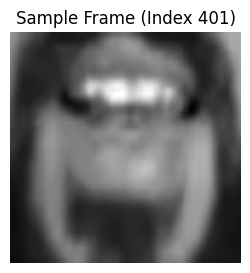

    [Prediction] Performing inference...
    [Prediction] Predicted Text : 'اللي كاينه في اوروبا م الره اللي كاينه في المغرب معارفينش معلومات عليها'
    [Prediction] Ground Truth Text: 'اللي كاينه في اوروبا اما الشركه اللي كاينه في المغرب معارفينش معلومات عليها'

--- Prediction Cell Done ---


In [20]:
# Cell 8: Load Saved Model and Make Predictions (Optional)
print("--- Loading Saved Model and Making Predictions ---")
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import traceback

# --- Configuration for Prediction ---
# Choose which model weights to load for prediction
# MODEL_TO_LOAD_PATH = FINAL_MODEL_SAVE_PATH # To load the model just trained
MODEL_TO_LOAD_PATH = "/kaggle/working/model_fully_trained_16_05_09pm.pth" # Or specify a checkpoint path
# MODEL_TO_LOAD_PATH = "/kaggle/working/model_fully_trained.pth" # Or your original final model
print(f"Attempting to load model for prediction from: {MODEL_TO_LOAD_PATH}")

# Ensure necessary variables from Cell 4 (Configuration) are available:
# NUM_CLASSES, GRU_HIDDEN_DIM, GRU_NUM_LAYERS, BOTTLENECK_DIM, device, char_map_instance
# Ensure train_dataset is available if predicting on a sample from it (from Cell 5)

prediction_model = None
try:
    # 1. Instantiate the Model
    if NUM_CLASSES == -1: raise ValueError("NUM_CLASSES not set, run configuration cell.")
    prediction_model = NewVSRModel(
        num_classes=NUM_CLASSES, input_channel=1,
        rnn_hidden_size=GRU_HIDDEN_DIM, rnn_num_layers=GRU_NUM_LAYERS,
        bottleneck_dim=BOTTLENECK_DIM
    ).to(device)
    print("  [Prediction] Model architecture instantiated.")

    # 2. Load Saved Weights
    if os.path.exists(MODEL_TO_LOAD_PATH):
        print(f"  [Prediction] Weights file found at {MODEL_TO_LOAD_PATH}.")
        
        # If loading a checkpoint, it's a dictionary. If loading a final model, it might be just state_dict.
        loaded_content = torch.load(MODEL_TO_LOAD_PATH, map_location=device)
        
        if isinstance(loaded_content, dict) and 'model_state_dict' in loaded_content:
            prediction_model.load_state_dict(loaded_content['model_state_dict'])
            print("  [Prediction] Loaded 'model_state_dict' from checkpoint dictionary.")
            if 'epoch' in loaded_content: print(f"    Model from epoch: {loaded_content['epoch']}")
        elif isinstance(loaded_content, dict) and not 'model_state_dict' in loaded_content:
             prediction_model.load_state_dict(loaded_content) # Assuming the dict itself is the state_dict
             print("  [Prediction] Loaded weights (assumed dictionary is state_dict).")
        else: # Direct state_dict
            prediction_model.load_state_dict(loaded_content)
            print("  [Prediction] Loaded weights directly (assumed raw state_dict).")
        
        prediction_model.eval() # Set to evaluation mode
        print("  [Prediction] Model weights loaded and model set to eval mode.")

        # 3. Prepare Input Data (Example: from train_dataset)
        if 'train_dataset' in globals() and train_dataset is not None and len(train_dataset) > 0:
            sample_idx_to_predict = 401 # Change as needed
            print(f"  [Prediction] Fetching sample {sample_idx_to_predict} from train_dataset...")
            
            # Ensure dataset is available from Cell 5 execution
            sample_data = train_dataset[sample_idx_to_predict]
            if sample_data:
                sample_frames_tensor, sample_text_tensor_truth = sample_data
                print(f"    [Prediction] Sample frames tensor shape: {sample_frames_tensor.shape}")

                # Display a frame
                if sample_frames_tensor.ndim == 4 and sample_frames_tensor.shape[0] > 0 and sample_frames_tensor.shape[1] == 1: # T, C, H, W
                    frame_to_display = sample_frames_tensor[0, 0, :, :].cpu().numpy()
                    plt.figure(figsize=(3,3)); plt.imshow(frame_to_display, cmap='gray')
                    plt.title(f"Sample Frame (Index {sample_idx_to_predict})"); plt.axis('off'); plt.show()

                input_tensor = sample_frames_tensor.unsqueeze(0).to(device) # Add batch dim: B, T, C, H, W

                # 4. Make Prediction
                print("    [Prediction] Performing inference...")
                with torch.no_grad():
                    output_log_probs = prediction_model(input_tensor)
                
                predicted_indices = torch.argmax(output_log_probs.cpu(), dim=2)[0].tolist()
                predicted_text = char_map_instance.indices_to_text(predicted_indices)
                print(f"    [Prediction] Predicted Text : '{predicted_text}'")

                if sample_text_tensor_truth is not None:
                    true_indices = sample_text_tensor_truth.cpu().tolist()
                    true_text = char_map_instance.indices_to_text(true_indices, remove_blanks=False, remove_duplicates=False)
                    print(f"    [Prediction] Ground Truth Text: '{true_text}'")
            else:
                print(f"  [Prediction] ERREUR: Sample {sample_idx_to_predict} from train_dataset is None.")
        else:
            print("  [Prediction] train_dataset not available/empty. Cannot fetch sample for prediction.")
            print("             To predict on new data, load and preprocess it like VSRDataset.__getitem__.")
    else:
        print(f"  [Prediction] ERREUR: Weights file NOT FOUND at {MODEL_TO_LOAD_PATH}.")

except Exception as e_predict:
    print(f"  [Prediction] ERREUR during model loading or prediction: {e_predict}")
    traceback.print_exc()

print("\n--- Prediction Cell Done ---")